# Dataset Overview

### Imports & Constants

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from IPython.display import Image

DATASET_PATH = '../Kaggle data/meta-kaggle'

## Conceptual Model

### Utility functions

In [2]:
def summarize_cleaning_step(current_df_name, current_df, previous_df, original_df):
    """
    Prints the number of items after the current cleaning step and
    the percentages of items saved by the cleaning step with respect to
    the dataframe before its application and the original dataset.
    """
    current_df_len = current_df.shape[0]
    print('Number of {}: {:,d}'.format(current_df_name, current_df_len))
    
    number_of_removed_kernels = previous_df.shape[0] - current_df_len
    print('Number of kernels removed from the previous cleaning step: {:,d}'.format(number_of_removed_kernels))

    percentage_over_cleaned = current_df_len * 100 / previous_df.shape[0] 
    print('Percentage over the cleaned set: {:.2f}%'.format(percentage_over_cleaned))

    percentage_over_original = current_df_len * 100 / original_df.shape[0] 
    print('Percentage over the original set: {:.2f}%'.format(percentage_over_original))

### Data import

In [3]:
%%time

# KERNELS
dates_to_be_parsed = [
    'CreationDate',
    'EvaluationDate',
    'MadePublicDate',
    'MedalAwardDate'
]
%time kernels = pd.read_csv(os.path.join(DATASET_PATH, 'Kernels.csv'), parse_dates=dates_to_be_parsed)

# KERNEL VERSIONS
%time kernelVersions = pd.read_csv(os.path.join(DATASET_PATH, 'KernelVersions.csv'), parse_dates=['CreationDate'])
kernelVersions = kernelVersions[[
    'Id',
    'ScriptId',
    'ScriptLanguageId',
    'AuthorUserId',  # Is the author consistent with the source script?
    'CreationDate',  # How often the creation date is different from the source script's one?
    'VersionNumber',
    'TotalLines',  # Might this be a threshold? What's the distribution?
    'TotalVotes'  # How is this variable related to the source script's correspondent?
]]

# KERNEL LANGUAGES
%time kernelLanguages = pd.read_csv(os.path.join(DATASET_PATH, 'KernelLanguages.csv'))

# USERS
%time users = pd.read_csv(os.path.join(DATASET_PATH, 'Users.csv'), parse_dates=['RegisterDate'])

# USER ACHIEVEMENTS
dates_to_be_parsed = [
    'TierAchievementDate',
]
%time userAchievements = pd.read_csv(os.path.join(DATASET_PATH, 'UserAchievements.csv'), parse_dates=dates_to_be_parsed)

CPU times: user 2min, sys: 639 ms, total: 2min 1s
Wall time: 2min 2s
CPU times: user 7min 29s, sys: 4.29 s, total: 7min 34s
Wall time: 7min 39s
CPU times: user 3.39 ms, sys: 2.31 ms, total: 5.69 ms
Wall time: 12.9 ms
CPU times: user 8min 10s, sys: 4.04 s, total: 8min 14s
Wall time: 8min 23s
CPU times: user 16min 4s, sys: 4.77 s, total: 16min 8s
Wall time: 16min 13s
CPU times: user 33min 44s, sys: 13.9 s, total: 33min 58s
Wall time: 34min 20s


## Kernel Type & Language

### Table joins

Join `Kernels.csv` with `KernelVersions.csv`

In [4]:
kernels_currentVersion = pd.merge(
    kernels, kernelVersions,
    left_on='CurrentKernelVersionId', right_on='Id',
    suffixes=('', '_currentVersion'))

summarize_cleaning_step('kernels with current version info', kernels_currentVersion, kernels, kernels)

Number of kernels with current version info: 319,590
Number of kernels removed from the previous cleaning step: 42,274
Percentage over the cleaned set: 88.32%
Percentage over the original set: 88.32%


Join the result of the previous operation with `KernelLanguages.csv`

In [5]:
kernel_currentVersion_language = pd.merge(
    kernels_currentVersion, kernelLanguages,
    left_on='ScriptLanguageId', right_on='Id',
    suffixes=('', '_language'))

summarize_cleaning_step('kernels with language info', kernel_currentVersion_language, kernels_currentVersion, kernels)

Number of kernels with language info: 318,855
Number of kernels removed from the previous cleaning step: 735
Percentage over the cleaned set: 99.77%
Percentage over the original set: 88.11%


Now we have isolated kernels with info about their current version and the associated language and type.

In particular, each kernel version is associated with one of these *"kernel languages"*.

In [6]:
kernelLanguages

,Id,Name,DisplayName,IsNotebook
0,1,R,R,False
1,2,Python,Python,False
2,5,RMarkdown,R,False
3,8,IPython Notebook,Python,True
4,9,IPython Notebook HTML,Python,False
5,12,R Notebook HTML,R,False
6,13,R Notebook,R,True
7,14,Python Script - Interactive,Python,True
8,15,R Script - Interactive,R,True
9,16,RMarkdown - Interactive,R,True


I need to focus on Python kernels, so I filter out the table accordingly.

In [7]:
kernelLanguages[kernelLanguages['DisplayName']=='Python']

,Id,Name,DisplayName,IsNotebook
1,2,Python,Python,False
3,8,IPython Notebook,Python,True
4,9,IPython Notebook HTML,Python,False
7,14,Python Script - Interactive,Python,True


From now on, I will refer to this table with the name: *languages table*.

### The kernel/kernel version author problem

I need to manually inspect a couple of samples from each python entry in the table; therefore I need to get the link to the kernel on kaggle.com. The link is formed with the *author's username* and the kernel's *current slug*.

But what's the correct meaning of kernel *"author"*?
Is there any difference between a kernel's author and one of its versions author?


In [8]:
kernels_currentVersion[
    kernels_currentVersion['AuthorUserId'] != kernels_currentVersion['AuthorUserId_currentVersion']].shape[0]

1069

Yes, evidently there is. At least for 822 rows.
So I guess that I should use the author ID from the KernelVersions table: he must be the actual author of the notebook that I will download via the API and assess.

I further join the dataframe resulting from the previous join operations with `Users.csv`.

In [9]:
kernel_currentVersion_language_author = pd.merge(
    kernel_currentVersion_language, users,
    left_on='AuthorUserId_currentVersion', right_on='Id',
    suffixes=('', '_author'))

summarize_cleaning_step('kernels with language and author info', kernel_currentVersion_language_author, kernel_currentVersion_language, kernels)

Number of kernels with language and author info: 315,077
Number of kernels removed from the previous cleaning step: 3,778
Percentage over the cleaned set: 98.82%
Percentage over the original set: 87.07%


Now I am able to produce lists of URLs for kernels belonging to each language in the *languages table*.
I will use the link to visit the kaggle.com pages and understand with a manual inspection the nature of the notebooks tagged with the 4 language names under assessment.

In [10]:
#  Python
python = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'Python'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# IPython Notebook
ipython_notebook = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'IPython Notebook'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# IPython Notebook HTML
ipython_notebook_html = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'IPython Notebook HTML'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# Python Script - Interactive
python_script_interactive = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'Python Script - Interactive'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

python_kernels = {
    'Python': python,
    'IPython Notebook': ipython_notebook,
    'IPython Notebook HTML': ipython_notebook_html,
    'Python Script - Interactive': python_script_interactive
}

for kernel in python_kernels:
    
    print('Number of kernels of type "{}": {:,d}'.format(kernel, python_kernels[kernel].shape[0]))
    
    python_kernels[kernel].sort_values('CreationDate_currentVersion', ascending=False)
    
    python_kernels[kernel]['url'] = 'https://www.kaggle.com/' + python_kernels[kernel]['UserName'] + '/' + python_kernels[kernel]['CurrentUrlSlug']
    python_kernels[kernel]['slug'] = python_kernels[kernel]['UserName'] + '/' + python_kernels[kernel]['CurrentUrlSlug']
    
    python_kernels[kernel]['url'].to_csv('notebook_output/{} - URLs.csv'.format(kernel), header=False, index=False)
    python_kernels[kernel]['slug'].to_csv('notebook_output/{} - slugs.csv'.format(kernel), header=False, index=False)
    

Number of kernels of type "Python": 21,259
Number of kernels of type "IPython Notebook": 49,498
Number of kernels of type "IPython Notebook HTML": 212,331
Number of kernels of type "Python Script - Interactive": 15


After a manual inspection of a sample of kernels from each language category (language name in the *languages table*) I discovered what follows.

- `Python` kernels are actual python scripts
- `IPython Notebook` kernels are not available anymore (for the most part)
- `IPython Notebook HTML` kernels are the HTML version of Jupyter Notebook files; they must have been produced using `nbconvert`; however, with the help of the Kaggle official API, it is possibile to download the source `.ipynb` notebook (without the output cells). With the help of a scraping script it might be also possible to download the source notebook with the output cells.
- `Python Script - Interactive` kernels are just 15 and are not available anymore.

`IPython Notebook` and `Python Script - Interactive` kernels might be old language tags that are not used anymore. I try to prove that by querying the `CreationDate` field from the `KernelVersions` table.


In [11]:
ipython_notebook['CreationDate_currentVersion'].describe()

count                   49498
unique                  49406
top       2017-01-10 18:20:52
freq                        3
first     2015-08-27 04:17:45
last      2018-04-18 17:30:49
Name: CreationDate_currentVersion, dtype: object

In [12]:
python_script_interactive['CreationDate_currentVersion'].describe()

count                      15
unique                     15
top       2018-02-25 11:22:21
freq                        1
first     2017-10-23 14:56:15
last      2018-04-13 02:14:54
Name: CreationDate_currentVersion, dtype: object

In both cases, kenrels of these kinds seem to have been dismissed during April 2018.

In [13]:
python['CreationDate_currentVersion'].describe()

count                   21259
unique                  21257
top       2017-04-05 17:38:52
freq                        2
first     2015-04-03 17:00:18
last      2020-06-18 19:13:17
Name: CreationDate_currentVersion, dtype: object

In [14]:
ipython_notebook_html['CreationDate_currentVersion'].describe()

count                  212331
unique                 211901
top       2018-10-11 20:06:49
freq                        8
first     2015-09-15 22:01:57
last      2020-06-19 00:02:19
Name: CreationDate_currentVersion, dtype: object

On the contrary, the other two types of kernel seem to span the whole period of time covered by the dataset.

In [15]:
# R
r = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'R'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# RMarkdown
rmarkdown = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'RMarkdown'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# R Notebook HTML
r_notebookHTML = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'R Notebook HTML'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# R Notebook
r_notebook = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'R Notebook'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# R Script - Interactive
r_script = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'R Script - Interactive'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# RMarkdown - Interactive
r_markdown_interactive = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'RMarkdown - Interactive'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

r_kernels = {
    'R': r,
    'RMarkdown': rmarkdown,
    'R Notebook HTML': r_notebookHTML,
    'R Notebook': r_notebook,
    'R Script - Interactive': r_script,
    'RMarkdown - Interactive': r_markdown_interactive
}

for kernel in r_kernels:
    
    print('Number of kernels of type "{}": {:,d}'.format(kernel, r_kernels[kernel].shape[0]))
    
    r_kernels[kernel].sort_values('CreationDate_currentVersion', ascending=False)
    
    r_kernels[kernel]['url'] = 'https://www.kaggle.com/' + r_kernels[kernel]['UserName'] + '/' + r_kernels[kernel]['CurrentUrlSlug']
    r_kernels[kernel]['slug'] = r_kernels[kernel]['UserName'] + '/' + r_kernels[kernel]['CurrentUrlSlug']
    
    r_kernels[kernel]['url'].to_csv('notebook_output/{} - URLs.csv'.format(kernel), header=False, index=False)
    r_kernels[kernel]['slug'].to_csv('notebook_output/{} - slugs.csv'.format(kernel), header=False, index=False)

Number of kernels of type "R": 10,979
Number of kernels of type "RMarkdown": 5,349
Number of kernels of type "R Notebook HTML": 12,691
Number of kernels of type "R Notebook": 2,950
Number of kernels of type "R Script - Interactive": 4
Number of kernels of type "RMarkdown - Interactive": 1


After a manual inspection of a sample of kernels from each R language category, I discovered what follows.

- `R` kernels are actual R scripts;
- `RMarkdown` kernels are RMarkdown files (with extention `.Rmd`);
- `R Notebook HTML` kernels are the HTML version of Jupyter Notebook files; they must have been produced using `nbconvert`; however, with the help of the Kaggle official API, it is possibile to download the source `.ipynb` notebook (without the output cells). With the help of a scraping script it might be also possible to download the source notebook with the output cells.
- `R Notebook` kernels are in the `.xrnb` format.
- `R Script - Interactive` are just a few (4) and they are in the `.xrnb` format.
- `RMarkdown - Interactive` is just one file in the `.xrnb` format. 

I need to work with Jupyter Notebook files (with extension `.ipynb`), so the only R language category I'm interested in is `R Notebook HTML`.

In [16]:
r_notebookHTML['CreationDate_currentVersion'].describe()

count                   12691
unique                  12685
top       2017-12-18 02:31:47
freq                        3
first     2015-11-06 03:56:10
last      2020-06-18 23:26:51
Name: CreationDate_currentVersion, dtype: object

I am interested in the analysis of Jupyter Notebooks, therefore I will analyse only kernels marked as `IPython Notebook HTML` and `R Notebook HTML`.

For now I limit the analysis to Python notebooks.

In [17]:
# df = kernel_currentVersion_language_author[
#     (kernel_currentVersion_language_author['Name'] == 'IPython Notebook HTML') | (kernel_currentVersion_language_author['Name'] == 'R Notebook HTML')
# ]

df = kernel_currentVersion_language_author[kernel_currentVersion_language_author['Name'] == 'IPython Notebook HTML']

# summarize_cleaning_step('Python and R Jupyter Notebook kernels', df, kernel_currentVersion_language_author, kernels)
summarize_cleaning_step('Python Jupyter Notebook kernels', df, kernel_currentVersion_language_author, kernels)

Number of Python Jupyter Notebook kernels: 212,331
Number of kernels removed from the previous cleaning step: 102,746
Percentage over the cleaned set: 67.39%
Percentage over the original set: 58.68%


## User achievements: filtering notebooks from non expert users

In [18]:
userAchievements.AchievementType.value_counts()

Discussion      3570705
Competitions    3570705
Scripts         3570705
Name: AchievementType, dtype: int64

In [19]:
userAchievements.groupby('UserId')['Id'].count().value_counts()

3    3570705
Name: Id, dtype: int64

Each user is associated with 3 rows in `UserAchievements.csv`. Each row describe the achievement of the user in one of the four *categories of expertise* mentioned in the [Kaggle Documentation](https://www.kaggle.com/progression).

Of the four categories of expertise (`Competitions`, `Notebooks`, `Datasets`, and `Discussion`), only four are covered by the available data: rows for the `Datasets` category are missing in meta-kaggle. The category of expertise is defined by the field `AchievementType`.

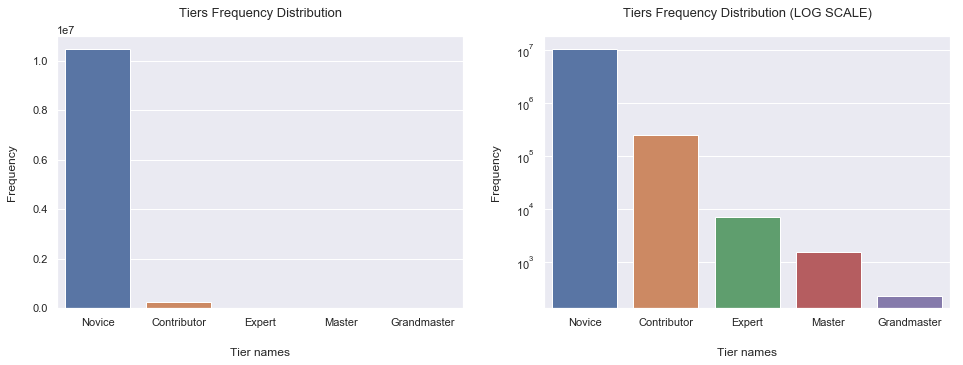

In [20]:
tiers = userAchievements.Tier.value_counts()
tiers_labels = [
    'Novice',
    'Contributor',
    'Expert',
    'Master',
    'Grandmaster'
]

plt.subplot(121)
sns.barplot(tiers_labels, tiers.values)
plt.title('Tiers Frequency Distribution', fontsize=13, pad=20)
plt.xlabel('Tier names', labelpad=20)
plt.ylabel('Frequency', labelpad=15)


plt.subplot(122)
sns.barplot(tiers_labels, tiers.values, log=True)
plt.title('Tiers Frequency Distribution (LOG SCALE)', fontsize=13, pad=20)
plt.xlabel('Tier names', labelpad=20)
plt.ylabel('Frequency', labelpad=15)

plt.gcf().set_size_inches(16,5)

In [21]:
tiers_scripts = userAchievements.loc[userAchievements['AchievementType'] == 'Scripts', ['Tier']].Tier.value_counts()
tiers_competitions = userAchievements.loc[userAchievements['AchievementType'] == 'Competitions', ['Tier']].Tier.value_counts()
tiers_discussions = userAchievements.loc[userAchievements['AchievementType'] == 'Discussion', ['Tier']].Tier.value_counts()

tiers_summary_df_map = {
    'Tier name':tiers_labels,
    'Scripts': tiers_scripts,
    'Competitions': tiers_competitions,
    'Discussions': tiers_discussions,
    'TOTAL frequency': tiers
}
tiers_summary_df = pd.DataFrame(tiers_summary_df_map)
tiers_summary_df.set_index('Tier name')

,Scripts,Competitions,Discussions,TOTAL frequency
Tier name,,,,
Novice,3485959,3485959,3485959,10457877
Contributor,83836,77610,83825,245271
Expert,785,5528,844,7157
Master,100,1423,54,1577
Grandmaster,25,185,23,233


Notebooks to be analised must be made by users that are at least in the `Expert` tier in at least one of the categories of expertise. I further filter out the notebooks collected so far according to this criterion.

In [22]:
expert_achievements = userAchievements[userAchievements['Tier']>1]
experts = expert_achievements.UserId.unique()
experts.shape[0]

7881

There are 7604 users that are in the `Expert`, `Master` or `Grandmaster` tier in one of the three categories of expertise: `Competition`, `Notebook`, `Discussion`.

I now filter notebooks by these knoledgeable authors.

In [23]:
notebooks_by_experts = df[df['AuthorUserId_currentVersion'].isin(experts)]
notebooks_by_beginners = df[~df['AuthorUserId_currentVersion'].isin(experts)]

summarize_cleaning_step('Jupyter Notebooks from experts', notebooks_by_experts, df, kernels)

Number of Jupyter Notebooks from experts: 57,519
Number of kernels removed from the previous cleaning step: 154,812
Percentage over the cleaned set: 27.09%
Percentage over the original set: 15.90%


In [24]:
print("# of notebooks to be partitioned: {:,}".format(df.shape[0]))
print("# of notebooks by esperts: {:,}".format(notebooks_by_experts.shape[0]))
print("# of notebooks by beginners: {:,}".format(notebooks_by_beginners.shape[0]))

# of notebooks to be partitioned: 212,331
# of notebooks by esperts: 57,519
# of notebooks by beginners: 154,812


### Visualization of the filtering steps

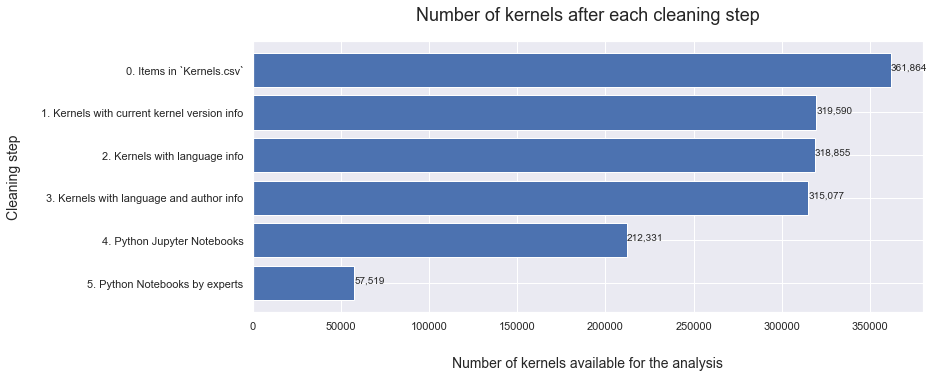

In [25]:
steps = {
    '5. Python Notebooks by experts': notebooks_by_experts.shape[0],
    '4. Python Jupyter Notebooks': df.shape[0],
    '3. Kernels with language and author info': kernel_currentVersion_language_author.shape[0],
    '2. Kernels with language info': kernel_currentVersion_language.shape[0],
    '1. Kernels with current kernel version info': kernels_currentVersion.shape[0],
    '0. Items in `Kernels.csv`': kernels.shape[0]
}

plt.barh(y=list(steps.keys()), width=list(steps.values()))
for index, value in enumerate(list(steps.values())):
    plt.text(value, index, '{:,d}'.format(value))
    
plt.title("Number of kernels after each cleaning step", fontsize=18, pad=20)
plt.xlabel("Number of kernels available for the analysis", fontsize=14, labelpad=25)
plt.ylabel("Cleaning step", fontsize=14, labelpad=20)
    
plt.gcf().set_size_inches(12,5)

## Further minor filtering operations

### CurrentUrlSlug

To download the notebooks via the API I need the `CurrentUrlSlug`.
I make sure that every kernel in the dataset has a `CurrentUrlSlug`.

In [26]:
notebooks_by_experts[notebooks_by_experts['CurrentUrlSlug'].isna()].shape[0]

0

Every notebook in the dataset has a `CurrentUrlSlug`.

### IsProjectLanguageTemplate

After a manual inspection, I realized that kernels marked with the flag `IsProjectLanguageTemplate` are not to be included in the analysis. They are, as the name of the flag suggests, just templates, maybe provided to participants in the beginning of challenges.

In [27]:
notebooks_by_experts[notebooks_by_experts['IsProjectLanguageTemplate']].shape[0]

0

After the filtering operations above, no *"project language template"* has survived, therefore the cleaning operations are completed.

## Output filtered URL/slug list

In [28]:
notebooks_by_experts.columns

Index(['Id', 'AuthorUserId', 'CurrentKernelVersionId',
       'ForkParentKernelVersionId', 'ForumTopicId', 'FirstKernelVersionId',
       'CreationDate', 'EvaluationDate', 'MadePublicDate',
       'IsProjectLanguageTemplate', 'CurrentUrlSlug', 'Medal',
       'MedalAwardDate', 'TotalViews', 'TotalComments', 'TotalVotes',
       'Id_currentVersion', 'ScriptId', 'ScriptLanguageId',
       'AuthorUserId_currentVersion', 'CreationDate_currentVersion',
       'VersionNumber', 'TotalLines', 'TotalVotes_currentVersion',
       'Id_language', 'Name', 'DisplayName', 'IsNotebook', 'Id_author',
       'UserName', 'DisplayName_author', 'RegisterDate', 'PerformanceTier'],
      dtype='object')

In [29]:
notebooks_by_experts['url'] = 'https://www.kaggle.com/' + notebooks_by_experts['UserName'] + '/' + notebooks_by_experts['CurrentUrlSlug']
notebooks_by_experts['full_download_url'] = 'https://www.kaggle.com/kernels/scriptcontent/' + notebooks_by_experts['CurrentKernelVersionId'].astype('int64').astype('str') + '/download'
notebooks_by_experts['slug'] = notebooks_by_experts['UserName'] + '/' + notebooks_by_experts['CurrentUrlSlug']

notebooks_by_beginners['url'] = 'https://www.kaggle.com/' + notebooks_by_beginners['UserName'] + '/' + notebooks_by_beginners['CurrentUrlSlug']
notebooks_by_beginners['full_download_url'] = 'https://www.kaggle.com/kernels/scriptcontent/' + notebooks_by_beginners['CurrentKernelVersionId'].astype('int64').astype('str') + '/download'
notebooks_by_beginners['slug'] = notebooks_by_beginners['UserName'] + '/' + notebooks_by_beginners['CurrentUrlSlug']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

### URLs

In [30]:
notebooks_by_experts['url'].to_csv('notebook_output/Notebooks by experts - URLs.csv', header=False, index=False)
notebooks_by_beginners['url'].to_csv('notebook_output/Notebooks by beginners - URLs.csv', header=False, index=False)

### Slugs

In [31]:
notebooks_by_experts['slug'].to_csv('notebook_output/Notebooks by experts - slugs.csv', header=False, index=False)
notebooks_by_beginners['slug'].to_csv('notebook_output/Notebooks by beginners - slugs.csv', header=False, index=False)

### Full download URLs

In [32]:
notebooks_by_experts.to_csv('notebook_output/Notebooks by experts - full download URLs.csv', columns=['slug', 'full_download_url'], header=['slug', 'url'], index=False)
notebooks_by_beginners.to_csv('notebook_output/Notebooks by beginners - full download URLs.csv', columns=['slug', 'full_download_url'], header=['slug', 'url'], index=False)

# Some EDA

In [33]:
notebooks_by_experts.CreationDate_currentVersion.describe()

count                   57519
unique                  57403
top       2018-10-11 20:06:49
freq                        8
first     2015-09-15 22:01:57
last      2020-06-18 23:57:11
Name: CreationDate_currentVersion, dtype: object